<font color="red" size=4>Kaggle competition **Tabular Playground Series - May 2022** final solution kernel</font>
- May 2022 PLayground competition was binary classificationbased on tabular data, 
- My personal goal was to evaluate two implementations of neutal network dedicated to solve tabular data problems
> - the first TabNet implementation was based on Tensorflow framework
> - the second - Torch framework
- I was interested in several aspects of comparison, but especially:
> - the results in comparison with my favourite tools used for this kind of problem 
<br>(one of gradient boosting solutions (XGBoost/LightGBM/CatBoost))
> - the comparison working speed of Tensorflow and Torch implmentation

Theere were train data composed of 900 000 records and test data (700 000).
The features were:
- in some part numerical (float and continuous), 
- in come - categorical (with 2 to 16 levels) 
- one more complex feature, 30 of them all over.

This script contains the final solution, composed of traiing and prediction using:
1. Tensorflow TabNet implementation
2. PyTorch TabNet implementation
3. XGB, LightGBM and CatBoost implementation

The final conclusion is:
- **On overall, any of tested TabNet implementation performs better than boosters**
- **The price of this performance improvement one must accept to pay**  is much longer time of neural based solution training 

The final score I achieved during the competition was 0.99810 in comparison to 0.99833 winning value

In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES']="1"
import numpy as np
import pandas as pd
import itertools
import warnings
import lightgbm
import sklearn
import xgboost
import catboost
import matplotlib.ticker as ticker
import datetime as dt
from tabulate import tabulate
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import tensorflow as tf
from tabnet.models.classify import TabNetClassifier as TFTabnetClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tabnet.schedules import DecayWithWarmupSchedule
from tensorflow.keras.callbacks import Callback
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint
from pytorch_tabnet.tab_model import TabNetClassifier as TorchTabnetClassifier
import torch
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

for m in [pd,sklearn,xgboost, catboost, lightgbm, tf, torch]:
    print(f"{m.__name__}: {m.__version__}")
    
pd.options.display.max_columns=0
warnings.filterwarnings('ignore')

2022-06-03 00:47:54.684386: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


pandas: 1.4.2
sklearn: 1.0.2
xgboost: 1.6.0
catboost: 1.0.5
lightgbm: 3.3.2
tensorflow: 2.4.0
torch: 1.10.1+cu102


# Data preparation

## Loading

In [2]:
# Oryginal Kaggle csv converted to pickle to save space
# visit https://www.kaggle.com/competitions/tabular-playground-series-may-2022/data

SRCTRAIN="/mnt/workdata/_WORK_/Kaggle_202005_Tab/Data/oryginal/pkl/train.pkl"
SRCTEST="/mnt/workdata/_WORK_/Kaggle_202005_Tab/Data/oryginal/pkl/test.pkl"

train_df = pd.read_pickle(SRCTRAIN)
test_df = pd.read_pickle(SRCTEST)

df=train_df.append(test_df)
target=df['target']
df=df.iloc[:,:-1]

In [3]:
train_df.head()


,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,1,3,3,3,1,6,1,0,7,4,0.298218,-0.919717,3.058541,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,4,0,2,3,0,1,0,4,6,0,-3.147667,-1.075434,2.179050,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,2,6,6,4,3,1,2,2,1,4,2.820733,-3.485342,-0.784235,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,1,0,1,6,4,2,3,3,0,3,1.081084,-2.100177,-2.343819,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,0,4,3,0,6,0,3,3,1,0,-0.126179,0.605033,1.133665,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1


## F27 decomposition

### Pattern distance

In [4]:
z_distance_data_cols = [f"f_27_{i+1}" for i in range(10)]
z_distance_data = pd.DataFrame(df['f_27'].apply(list).tolist(), columns=z_distance_data_cols)
for feature in z_distance_data_cols:
    z_distance_data[feature] = z_distance_data[feature].apply(lambda x: ord('Z') - ord(x))
z_distance_data.head()

,f_27_1,f_27_2,f_27_3,f_27_4,f_27_5,f_27_6,f_27_7,f_27_8,f_27_9,f_27_10
0,25,24,25,24,22,25,22,24,25,24
1,25,23,25,23,23,25,22,23,21,24
2,25,25,25,21,25,24,23,15,25,22
3,24,22,24,24,25,25,23,24,23,24
4,24,22,24,23,24,24,23,18,20,21


In [5]:
df=df.join(z_distance_data)

## Other features

In [6]:
df['f_27_uc'] = df['f_27'].apply(lambda x : len(set(x)))


## Interaction features

In [7]:
df["f_02_f_21_sum_hist"] = df.apply(lambda r: 1 if (r['f_02']+r['f_21'])<-5.3 else 2 if (r['f_02']+r['f_21'])>5.2 else 0, axis=1)
df["f_05_f_22_sum_hist"] = df.apply(lambda r: 1 if (r['f_05']+r['f_22'])<-5.4 else 2 if (r['f_05']+r['f_22'])>5.1 else 0, axis=1)
df["f_00_01_26"] = df.apply(lambda r: 2 if (r['f_00']+r['f_01']+r["f_26"])<-5 else 1 if (r['f_00']+r['f_01']+r["f_26"])>5 else 0 , axis=1)

## Final dataset

In [8]:
df=df.join(target)
del df['f_27']

In [9]:
print(df.shape)
df.head()

(1600000, 45)


,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30,f_27_1,f_27_2,f_27_3,f_27_4,f_27_5,f_27_6,f_27_7,f_27_8,f_27_9,f_27_10,f_27_uc,f_02_f_21_sum_hist,f_05_f_22_sum_hist,f_00_01_26,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,1,3,3,3,1,6,1,0,7,4,0.298218,-0.919717,3.058541,-2.540739,0.766952,-2.730628,-0.208177,1.363402,67.609153,0,0,25,24,25,24,22,25,22,24,25,24,3,0,0,0,0.0
1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,4,0,2,3,0,1,0,4,6,0,-3.147667,-1.075434,2.179050,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,377.096415,0,0,25,23,25,23,23,25,22,23,21,24,5,0,0,0,1.0
2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,2,6,6,4,3,1,2,2,1,4,2.820733,-3.485342,-0.784235,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,-195.599702,0,2,25,25,25,21,25,24,23,15,25,22,6,0,0,0,1.0
3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,1,0,1,6,4,2,3,3,0,3,1.081084,-2.100177,-2.343819,0.572594,-1.653213,1.686035,-2.533098,-0.608601,210.826205,0,0,24,22,24,24,25,25,23,24,23,24,4,0,0,0,1.0
4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,0,4,3,0,6,0,3,3,1,0,-0.126179,0.605033,1.133665,-3.912929,-1.430366,2.127649,-3.306784,4.371371,-217.211798,0,1,24,22,24,23,24,24,23,18,20,21,6,0,0,1,1.0


In [10]:
train_df=df.loc[pd.isna(df['target'])==False,:]
train_df['target']=train_df['target'].astype(int)
test_df=df.loc[pd.isna(df['target'])==True,:].iloc[:,:-1]
print(train_df.shape)
print(test_df.shape)

(900000, 45)
(700000, 44)


## Data crossvalidation

In [11]:
NUM_SPLITS=10
skf = StratifiedKFold(n_splits=NUM_SPLITS)
folds = dict()
folds_results = dict()


idx = 0
train_data=train_df.iloc[:,:-1]
train_labels=train_df.iloc[:,-1]

for split in skf.split(train_data, train_labels ):
    folds[idx] = {'X_train': train_data.iloc[split[0],:], 
                  'y_train':  train_labels.iloc[split[0]], 
                  'X_val': train_data.iloc[split[1],:], 
                  'y_val':  train_labels.iloc[split[1]]
                  }
    print(f"Fold: {idx}, X_train {folds[idx]['X_train'].shape}, X_val {folds[idx]['X_val'].shape}")
    idx+=1

Fold: 0, X_train (810000, 44), X_val (90000, 44)
Fold: 1, X_train (810000, 44), X_val (90000, 44)
Fold: 2, X_train (810000, 44), X_val (90000, 44)
Fold: 3, X_train (810000, 44), X_val (90000, 44)
Fold: 4, X_train (810000, 44), X_val (90000, 44)
Fold: 5, X_train (810000, 44), X_val (90000, 44)
Fold: 6, X_train (810000, 44), X_val (90000, 44)
Fold: 7, X_train (810000, 44), X_val (90000, 44)
Fold: 8, X_train (810000, 44), X_val (90000, 44)
Fold: 9, X_train (810000, 44), X_val (90000, 44)


In [12]:
# store folds for future use with various models

# with open('crossvalidated_10_folds.pkl', "wb") as f:
#     pickle.dump(folds, f)

In [13]:
# use the same splitting as for TabNet
# with open('crossvalidated_10_folds.pkl', "rb") as f:
#     folds = pickle.load(f)

# XGBoost prediction


## Params definition

In [22]:
# The parameters were determined using 80 iterations of simulated anneal, non-crossvalidated, preserving only data proportion

params = {
  "n_estimators": 5000,
  "booster": "gbtree",
  "tree_method": "gpu_hist",
  "early_stopping_rounds": 10,
  "learning_rate": 0.12,
  "max_depth": 8,
  "min_child_weight": 0.974,
  "reg_lambda": 1.5190000000000001,
  "reg_alpha": 1.77,
  "max_bin": 432
}

## CV folds training

In [27]:
# to use results for stacking or blending
# define placeholders for validation data predictions and test data predictions
folds_results = dict()
test_predictions=dict()
folds_scores={}

### Training loop

In [33]:
start = dt.datetime.now()
N_ATTEMPTS_PER_FOLD=1 # the results are repeatable, so multiple attempts for XGB do not make sense

# level 0 loop for folds
for idx in folds.keys():
    print(f"Starting fold {idx}")
    ss = StandardScaler()
    X_train_fold_scaled = pd.DataFrame(ss.fit_transform(folds[idx]['X_train']), 
                                       index=folds[idx]['X_train'].index, 
                                       columns=folds[idx]['X_train'].columns)
    X_val_fold_scaled = pd.DataFrame(ss.transform(folds[idx]['X_val']), 
                                     index=folds[idx]['X_val'].index, 
                                     columns=folds[idx]['X_val'].columns)
    
    # nested loop for attempts within each fold
    # each attempt operates on the same data
    for attempt in range(N_ATTEMPTS_PER_FOLD):
        print(f"Starting attempt {attempt} in fold {idx}")
        CHECKPOINTS_PATH=f"xgb_checkpoints/{idx}_{attempt}/"
        tf.keras.backend.clear_session()
   
        model_xgb= XGBClassifier(
            n_estimators=params['n_estimators'],
            learning_rate=params['learning_rate'],
            max_depth=params['max_depth'],
            min_child_weight = params['min_child_weight'],
            reg_lambda = params['reg_lambda'],
            reg_alpha = params['reg_alpha'],
            max_bin = params['max_bin'],
            booster=params['booster'],
            eval_metric=['auc'],
            early_stopping_rounds=params['early_stopping_rounds'],
            tree_method=params['tree_method'],
        )

        model_xgb.fit(X_train_fold_scaled, folds[idx]['y_train'], 
                      eval_set=[(X_val_fold_scaled,  folds[idx]['y_val'])], 
                      verbose=False)
        if not os.path.isdir(CHECKPOINTS_PATH):
            os.mkdir(CHECKPOINTS_PATH)
        model_xgb.save_model(CHECKPOINTS_PATH+"xgb_model.pkl")
        # load the best weights
        
        folds_results[((idx, attempt), 'XGBpolecenieererer')]= model_xgb.predict_proba(X_val_fold_scaled.values)[:,1]
        fold_auc = roc_auc_score(folds[(idx)]['y_val'], folds_results[((idx, attempt), 'TabNet')])
        folds_scores[(idx, attempt)]=fold_auc
        print(f"Final fold-attempt result: {fold_auc:.6f}\n\n")
    print("Performed fold {} attempt {}".format(idx, attempt))
print(f"Performed in {dt.datetime.now()-start}")

Starting fold 0
Starting attempt 0 in fold 0
Final fold-attempt result: 0.996161


Performed fold 0 attempt 0
Starting fold 1
Starting attempt 0 in fold 1
Final fold-attempt result: 0.996043


Performed fold 1 attempt 0
Starting fold 2
Starting attempt 0 in fold 2
Final fold-attempt result: 0.996447


Performed fold 2 attempt 0
Starting fold 3
Starting attempt 0 in fold 3
Final fold-attempt result: 0.996264


Performed fold 3 attempt 0
Starting fold 4
Starting attempt 0 in fold 4
Final fold-attempt result: 0.996397


Performed fold 4 attempt 0
Starting fold 5
Starting attempt 0 in fold 5
Final fold-attempt result: 0.996391


Performed fold 5 attempt 0
Starting fold 6
Starting attempt 0 in fold 6
Final fold-attempt result: 0.996557


Performed fold 6 attempt 0
Starting fold 7
Starting attempt 0 in fold 7
Final fold-attempt result: 0.996084


Performed fold 7 attempt 0
Starting fold 8
Starting attempt 0 in fold 8
Final fold-attempt result: 0.996404


Performed fold 8 attempt 0
Starting f

In [34]:
xgb_res__={
    "folds_scores": folds_scores,
    "folds": folds,
    "folds_val_predictions": folds_results,
}
with open("XGBResults.pkl", "wb") as f:
    pickle.dump(xgb_res__,f)

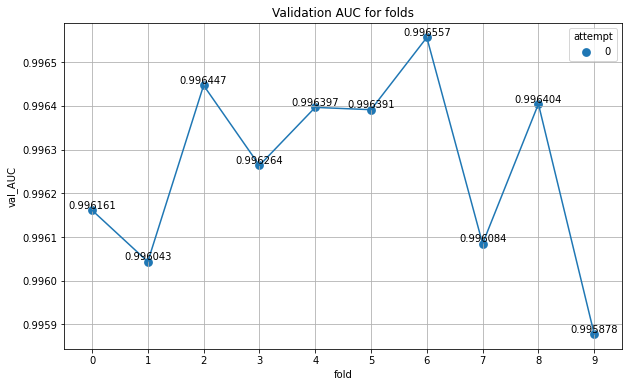

In [35]:
score_df=pd.DataFrame.from_dict(folds_scores, orient='index', columns=['val_AUC'])
score_df=score_df.reset_index()
score_df['fold']=score_df['attempt']=np.NaN
score_df['fold']=score_df['index'].apply(lambda x: x[0])
score_df['attempt']=score_df['index'].apply(lambda x: x[1])
score_df.sort_values(by=['fold','attempt']).reset_index()
score_df=score_df[['fold','attempt','val_AUC']]
fig,ax=plt.subplots(1,1,figsize=(10,6))
sns.lineplot(data=score_df, x='fold', y='val_AUC',  ax=ax, err_style='bars')
score_df_best = score_df.loc[score_df.groupby('fold')['val_AUC'].idxmax()]
sns.pointplot(data=score_df_best, x='fold', y='val_AUC', hue='attempt', linestyles='', ax=ax)
for idx, fold, val in list(score_df_best[['fold', 'val_AUC']].itertuples()):
    ax.text(fold, val, f"{val:.6f}", horizontalalignment='center', verticalalignment='bottom')
    
ax.grid('both')
ax.set_title('Validation AUC for folds');


In [39]:
for fold, attempt, val in score_df_best.values:
    CHECKPOINTS_PATH=f"xgb_checkpoints/{int(fold)}_{int(attempt)}/"
    print(CHECKPOINTS_PATH)
    model_xgb=XGBClassifier()
    model_xgb.load_model(CHECKPOINTS_PATH+"xgb_model.pkl")
    ss.fit(folds[fold]['X_train'])
    x_val_fold_scaled=ss.transform(folds[fold]['X_val'])
    folds_results[(fold, 'xgb')]= model_xgb.predict_proba(x_val_fold_scaled)[:,1]
    test_df_=ss.transform(test_df)
    test_predictions[fold]=model_xgb.predict_proba(test_df_)[:,1]

xgb_checkpoints/0_0/
xgb_checkpoints/1_0/
xgb_checkpoints/2_0/
xgb_checkpoints/3_0/
xgb_checkpoints/4_0/
xgb_checkpoints/5_0/
xgb_checkpoints/6_0/
xgb_checkpoints/7_0/
xgb_checkpoints/8_0/
xgb_checkpoints/9_0/


<AxesSubplot:>

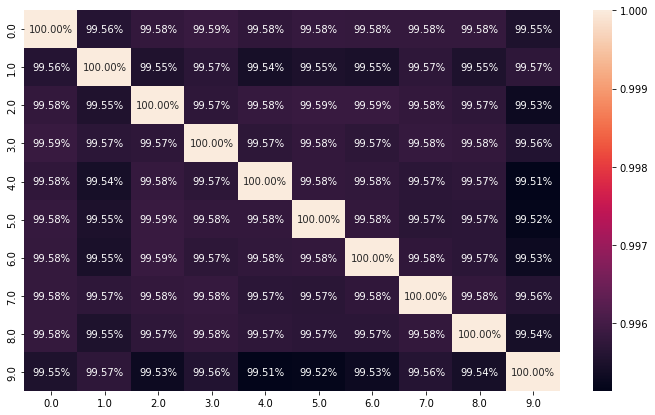

In [40]:
test_pred_df = pd.DataFrame(test_predictions)
fig,ax=plt.subplots(1,1,figsize=(12,7))
sns.heatmap(test_pred_df.corr(), annot=True, fmt=".2%")


## Mean prediction using all data

In [41]:
with open("XGB_test_preds.pkl", "wb") as f:
    pickle.dump(test_predictions, f)

In [42]:
res_=pd.DataFrame(test_pred_df.mean(axis=1),  columns=['target'])
res_. index=test_df.index
res_.to_csv("Finalsolution_data30_xgb.csv")

This submission scored 0.99660

# CatBoost prediction

## Params definition

In [51]:
params = {
  "iterations": 20000,
  "learning_rate": 0.013717390733915782,
  "depth": 11,
  "l2_leaf_reg": 3.7920000000000003,
  "use_best_model": True,
  "random_strength": 0.9450000000000001,
  "eval_metric": "Logloss",
  "bagging_temperature": 0.406,
  "task_type": "GPU",
  "early_stopping_rounds": 10
}

## CV folds training

In [52]:
# to use results for stacking or blending
# define placeholders for validation data predictions and test data predictions
folds_results_cat = dict()
test_predictions_cat=dict()
val_predictions_cat=dict()
folds_scores_cat={}

### Training loop

In [53]:
N_ATTEMPTS_PER_FOLD=1
start=dt.datetime.now()
# level 0 loop for folds
for idx in folds.keys():
    print(f"Starting fold {idx}")
    ss = StandardScaler()
    X_train_fold_scaled = pd.DataFrame(ss.fit_transform(folds[idx]['X_train']), 
                                       index=folds[idx]['X_train'].index, 
                                       columns=folds[idx]['X_train'].columns)
    X_val_fold_scaled = pd.DataFrame(ss.transform(folds[idx]['X_val']), 
                                     index=folds[idx]['X_val'].index, 
                                     columns=folds[idx]['X_val'].columns)
    
    # nested loop for attempts within each fold
    # each attempt operates on the same data
    for attempt in range(N_ATTEMPTS_PER_FOLD):
        print(f"Starting attempt {attempt} in fold {idx}")
        CHECKPOINTS_PATH=f"cat_checkpoints/{idx}_{attempt}/"
        tf.keras.backend.clear_session()
   
        model_cat = CatBoostClassifier(
            iterations=params['iterations'],
            learning_rate=params['learning_rate'],
            depth= params['depth'],
            l2_leaf_reg = params['l2_leaf_reg'],
            random_strength = params['random_strength'],
            bagging_temperature = params['bagging_temperature'],

            eval_metric='Logloss',
            early_stopping_rounds=params['early_stopping_rounds'],
            task_type=params['task_type'],
            use_best_model=True,
        )


        model_cat.fit(X_train_fold_scaled, folds[idx]['y_train'], 
                      eval_set=[(X_val_fold_scaled,  folds[idx]['y_val'])], 
                      verbose=False)
        if not os.path.isdir(CHECKPOINTS_PATH):
            os.mkdir(CHECKPOINTS_PATH)
        model_cat.save_model(CHECKPOINTS_PATH+'cat_model')
        
        folds_results_cat[((idx, attempt), 'CatBoost')]= model_cat.predict_proba(X_val_fold_scaled.values)[:,1]
        fold_auc = roc_auc_score(folds[(idx)]['y_val'], folds_results_cat[((idx, attempt), 'CatBoost')])
        folds_scores_cat[(idx, attempt)]=fold_auc
        print(f"Final fold-attempt result: {fold_auc:.6f}\n\n")
    print("Performed fold {} attempt {}".format(idx, attempt))
print(f"Performed in {dt.datetime.now()-start}")

Starting fold 0
Starting attempt 0 in fold 0
Final fold-attempt result: 0.997142


Performed fold 0 attempt 0
Starting fold 1
Starting attempt 0 in fold 1
Final fold-attempt result: 0.997159


Performed fold 1 attempt 0
Starting fold 2
Starting attempt 0 in fold 2
Final fold-attempt result: 0.997254


Performed fold 2 attempt 0
Starting fold 3
Starting attempt 0 in fold 3
Final fold-attempt result: 0.997269


Performed fold 3 attempt 0
Starting fold 4
Starting attempt 0 in fold 4
Final fold-attempt result: 0.997171


Performed fold 4 attempt 0
Starting fold 5
Starting attempt 0 in fold 5
Final fold-attempt result: 0.997145


Performed fold 5 attempt 0
Starting fold 6
Starting attempt 0 in fold 6
Final fold-attempt result: 0.997373


Performed fold 6 attempt 0
Starting fold 7
Starting attempt 0 in fold 7
Final fold-attempt result: 0.997103


Performed fold 7 attempt 0
Starting fold 8
Starting attempt 0 in fold 8
Final fold-attempt result: 0.997264


Performed fold 8 attempt 0
Starting f

In [56]:
cat_res__={
    "folds_scores": folds_scores_cat,
    "folds": folds,
    "folds_val_predictions": folds_results_cat,
}
with open("CatBoostResults.pkl", "wb") as f:
    pickle.dump(cat_res__,f)

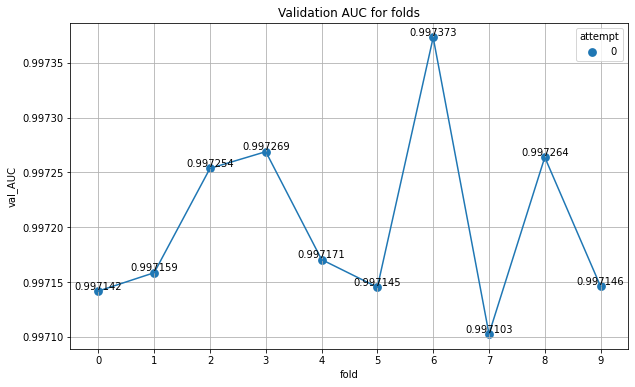

In [57]:
score_df=pd.DataFrame.from_dict(folds_scores_cat, orient='index', columns=['val_AUC'])
score_df=score_df.reset_index()
score_df['fold']=score_df['attempt']=np.NaN
score_df['fold']=score_df['index'].apply(lambda x: x[0])
score_df['attempt']=score_df['index'].apply(lambda x: x[1])
score_df.sort_values(by=['fold','attempt']).reset_index()
score_df=score_df[['fold','attempt','val_AUC']]
fig,ax=plt.subplots(1,1,figsize=(10,6))
sns.lineplot(data=score_df, x='fold', y='val_AUC',  ax=ax, err_style='bars')
score_df_best = score_df.loc[score_df.groupby('fold')['val_AUC'].idxmax()]
sns.pointplot(data=score_df_best, x='fold', y='val_AUC', hue='attempt', linestyles='', ax=ax)
for idx, fold, val in list(score_df_best[['fold', 'val_AUC']].itertuples()):
    ax.text(fold, val, f"{val:.6f}", horizontalalignment='center', verticalalignment='bottom')
    
ax.grid('both')
ax.set_title('Validation AUC for folds');


In [58]:
# some iterations here were performed in the other script
# tyhe mean value is only for folds 0-6
score_df=pd.DataFrame.from_dict(folds_scores_cat, orient='index')
print(f'Mean AUC: {score_df.mean()[0]:.6f} +/- {score_df.std()[0]:.6f}')


Mean AUC: 0.997202 +/- 0.000084


In [59]:
test_predictions=dict()
for idx in tqdm(folds.keys()):
    CHECKPOINTS_PATH=f"cat_checkpoints/{idx}_{attempt}/"
    model_cat = CatBoostClassifier()
    model_cat.load_model(CHECKPOINTS_PATH+"cat_model")
    ss.fit(folds[idx]['X_train'])
    x_val_fold_scaled=ss.transform(folds[idx]['X_val'])
    folds_results_cat[((idx, 0), 'CatBoost')]= model_cat.predict_proba(x_val_fold_scaled)[:,1]
    
    test_df_=ss.transform(test_df)
    test_predictions[idx]=model_cat.predict_proba(test_df_)[:,1]

100%|███████████████████████████████████████████| 10/10 [00:14<00:00,  1.44s/it]


In [ ]:
test_pred_df = pd.DataFrame(test_predictions)
fig,ax=plt.subplots(1,1,figsize=(12,7))
sns.heatmap(test_pred_df.corr(), annot=True, fmt=".2%")


## Mean prediction using all data

In [28]:
with open("CatBoost_test_preds_1.pkl", "wb") as f:
    pickle.dump(test_predictions, f)

In [29]:
res_=pd.DataFrame(test_pred_df.mean(axis=1),  columns=['target'])
res_. index=test_df.index
res_.to_csv("Finalsolution_data30_CatBoost_1.csv")

The result obtained is 0.99725 (Public)

# LGBM prediction

## Params definition

In [60]:
params = {
  "n_estimators": 10000,
  "boosting_type": "gbdt",
  "verbose": False,
  "learning_rate": 0.1,
  "early_stopping_round": 10,
  "subsample_for_bin": 190000,
  "num_leaves": 38,
  "reg_alpha": 0.365,
  "reg_lambda": 0.361,
  "min_child_samples": 18,
  "min_child_weight": 0.004200000000000001
}

## CV folds training

In [61]:
# to use results for stacking or blending
# define placeholders for validation data predictions and test data predictions
folds_results_lgbm = dict()
test_predictions_lgbm=dict()
val_predictions_lgbm=dict()
folds_scores_lgbm={}

### Training loop

In [62]:
N_ATTEMPTS_PER_FOLD=1
start=dt.datetime.now()
# level 0 loop for folds
for idx in folds.keys():
    print(f"Starting fold {idx}")
    ss = StandardScaler()
    X_train_fold_scaled = pd.DataFrame(ss.fit_transform(folds[idx]['X_train']), 
                                       index=folds[idx]['X_train'].index, 
                                       columns=folds[idx]['X_train'].columns)
    X_val_fold_scaled = pd.DataFrame(ss.transform(folds[idx]['X_val']), 
                                     index=folds[idx]['X_val'].index, 
                                     columns=folds[idx]['X_val'].columns)
    
    # nested loop for attempts within each fold
    # each attempt operates on the same data
    for attempt in range(N_ATTEMPTS_PER_FOLD):
        print(f"Starting attempt {attempt} in fold {idx}")
        CHECKPOINTS_PATH=f"lgbm_checkpoints/{idx}_{attempt}/"
  
        model_lgbm = LGBMClassifier(n_estimators=params['n_estimators'],
                               num_leaves=params['num_leaves'],
                               learning_rate=params['learning_rate'],
                               boosting_type = params['boosting_type'],
                               subsample_for_bin = params['subsample_for_bin'],
                               early_stopping_round=params['early_stopping_round'],
                               min_child_samples=params['min_child_samples'],
                               min_child_weight=params["min_child_weight"],
                               reg_alpha=params["reg_alpha"],
                               reg_lambda=params['reg_lambda'],
                               n_jobs=31)


        model_lgbm.fit(X_train_fold_scaled, folds[idx]['y_train'], 
                      eval_set=[(X_val_fold_scaled,  folds[idx]['y_val'])], 
                      verbose=False)
        if not os.path.isdir(CHECKPOINTS_PATH):
            os.mkdir(CHECKPOINTS_PATH)
        with open(CHECKPOINTS_PATH+'lgbm_model.pkl', "wb") as f:
            pickle.dump(model_lgbm, f)
            
        folds_results_lgbm[((idx, attempt), 'LGBM')]= model_lgbm.predict_proba(X_val_fold_scaled.values)[:,1]
        fold_auc = roc_auc_score(folds[(idx)]['y_val'], folds_results_lgbm[((idx, attempt), 'LGBM')])
        folds_scores_lgbm[(idx, attempt)]=fold_auc
        print(f"Final fold-attempt result: {fold_auc:.6f}\n\n")
    print("Performed fold {} attempt {}".format(idx, attempt))
print(f"Performed in {dt.datetime.now()-start}")

Starting fold 0
Starting attempt 0 in fold 0
Final fold-attempt result: 0.996442


Performed fold 0 attempt 0
Starting fold 1
Starting attempt 0 in fold 1
Final fold-attempt result: 0.996546


Performed fold 1 attempt 0
Starting fold 2
Starting attempt 0 in fold 2
Final fold-attempt result: 0.996423


Performed fold 2 attempt 0
Starting fold 3
Starting attempt 0 in fold 3
Final fold-attempt result: 0.996529


Performed fold 3 attempt 0
Starting fold 4
Starting attempt 0 in fold 4
Final fold-attempt result: 0.996546


Performed fold 4 attempt 0
Starting fold 5
Starting attempt 0 in fold 5
Final fold-attempt result: 0.996604


Performed fold 5 attempt 0
Starting fold 6
Starting attempt 0 in fold 6
Final fold-attempt result: 0.996671


Performed fold 6 attempt 0
Starting fold 7
Starting attempt 0 in fold 7
Final fold-attempt result: 0.996403


Performed fold 7 attempt 0
Starting fold 8
Starting attempt 0 in fold 8
Final fold-attempt result: 0.996590


Performed fold 8 attempt 0
Starting f

In [63]:
lgbm_res__={
    "folds_scores": folds_scores_lgbm,
    "folds": folds,
    "folds_val_predictions": folds_results_lgbm,
}
with open("LGBMResults.pkl", "wb") as f:
    pickle.dump(lgbm_res__,f)

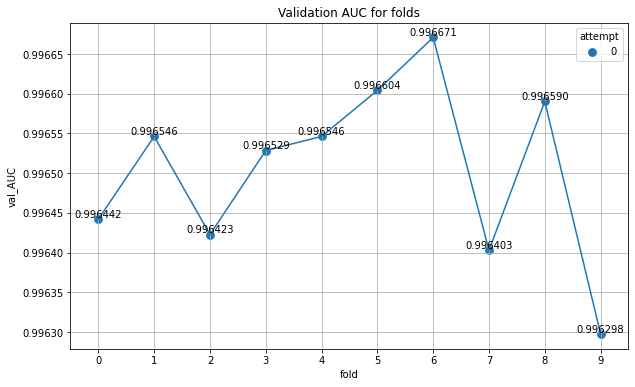

In [64]:
score_df=pd.DataFrame.from_dict(folds_scores_lgbm, orient='index', columns=['val_AUC'])
score_df=score_df.reset_index()
score_df['fold']=score_df['attempt']=np.NaN
score_df['fold']=score_df['index'].apply(lambda x: x[0])
score_df['attempt']=score_df['index'].apply(lambda x: x[1])
score_df.sort_values(by=['fold','attempt']).reset_index()
score_df=score_df[['fold','attempt','val_AUC']]
fig,ax=plt.subplots(1,1,figsize=(10,6))
sns.lineplot(data=score_df, x='fold', y='val_AUC',  ax=ax, err_style='bars')
score_df_best = score_df.loc[score_df.groupby('fold')['val_AUC'].idxmax()]
sns.pointplot(data=score_df_best, x='fold', y='val_AUC', hue='attempt', linestyles='', ax=ax)
for idx, fold, val in list(score_df_best[['fold', 'val_AUC']].itertuples()):
    ax.text(fold, val, f"{val:.6f}", horizontalalignment='center', verticalalignment='bottom')
    
ax.grid('both')
ax.set_title('Validation AUC for folds');


In [65]:
# some iterations here were performed in the other script
# tyhe mean value is only for folds 0-6
score_df=pd.DataFrame.from_dict(folds_scores_lgbm, orient='index')
print(f'Mean AUC: {score_df.mean()[0]:.6f} +/- {score_df.std()[0]:.6f}')


Mean AUC: 0.996505 +/- 0.000112


In [47]:
test_predictions=dict()
for idx in tqdm(folds.keys()):
    CHECKPOINTS_PATH=f"lgbm_checkpoints/{idx}_{attempt}/"
    with open(CHECKPOINTS_PATH+"lgbm_model.pkl", "rb") as f:
        model_lgbm = pickle.load(f)
    ss.fit(folds[idx]['X_train'])
    x_val_fold_scaled=ss.transform(folds[idx]['X_val'])
    folds_results_lgbm[((idx, 0), 'LGBM')]= model_lgbm.predict_proba(x_val_fold_scaled)[:,1]
    
    test_df_=ss.transform(test_df)
    test_predictions[idx]=model_lgbm.predict_proba(test_df_)[:,1]

100%|███████████████████████████████████████████| 10/10 [01:27<00:00,  8.75s/it]


<AxesSubplot:>

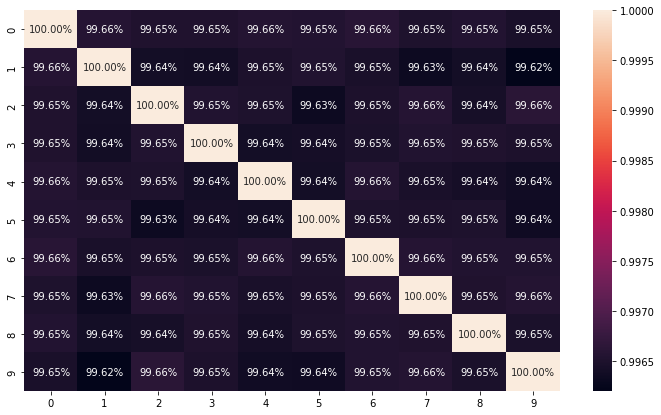

In [48]:
test_pred_df = pd.DataFrame(test_predictions)
fig,ax=plt.subplots(1,1,figsize=(12,7))
sns.heatmap(test_pred_df.corr(), annot=True, fmt=".2%")


## Mean prediction using all data

In [49]:
with open("lgbm_test_preds_1.pkl", "wb") as f:
    pickle.dump(test_predictions, f)

In [50]:
res_=pd.DataFrame(test_pred_df.mean(axis=1),  columns=['target'])
res_. index=test_df.index
res_.to_csv("Finalsolution_data30_LGBM_1.csv")

The result obtained is 0.99676 (Public)